In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import os
import sys
import scipy.stats
import matplotlib as mpl
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from compiler.ast import flatten
from sklearn.neighbors import NearestNeighbors
from itertools import groupby
import math
import networkx as nt
import gc
import psutil
import scipy.stats
#import Thestral
from scipy.stats.mstats import gmean

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph
from sklearn import cluster
from scipy.spatial.distance import pdist
from scipy.stats import pearsonr
import community
import matplotlib.gridspec as gridspec
import random
import re



/Users/liuqian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: The compiler package is deprecated and removed in Python 3.x.


In [2]:
#常用函数
def Mkdir(DirX):
    if not os.path.exists(DirX):
        os.mkdir(DirX)

def Read(File):
    return pd.read_table(File,sep='\t',index_col=0)

def ReadBed(File):
    Bed=pd.read_table(File,sep='\t',index_col=None,header=None)
    Bed.index=Bed[3]
    return Bed

def Save(DF,File):
    DF.to_csv(File,sep='\t')

def SaveBed(Bed,File):
    Bed.to_csv(File,sep='\t',index=False,header=False)
    
def GetState(i):
    if 'Norm' in i: return 'Norm'
    if 'Arm' in i: return 'Arm'
    if 'Back' in i:return 'Back'
    
    
def ReadTable(Infile):return pd.read_table(Infile,sep='\t',index_col=0)

def Mkdir(DirX):
    if not os.path.exists(DirX):
        os.mkdir(DirX)

def meanCenter(L):
    m=np.mean(L)
    return [i-m for i in L]

def log10(L):return -math.log(L,10)

def p_adjust_bh(p):
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig]

def ReadBed(BedFile):
    BedDF=pd.read_table(BedFile,sep='\t',header=None,index_col=None)
    BedDF.index=BedDF[3]
    return BedDF

def SaveTable(DF,FileName):DF.to_csv(FileName,sep='\t')
def SaveBed(BedDF,FileName):BedDF.to_csv(FileName,sep='\t',index=False,header=False)
def SizeFactor(DF):return (DF.T/DF.apply(gmean,axis=1)).dropna(axis=1,how='any').apply(np.median,axis=1)
  
    

In [3]:
inDir="./IFNSLESerum_BulkRNA-seq"

outDir=os.path.join(inDir,"OutPut")
ExpDir=os.path.join(inDir,'SourceData')
Signature=os.path.join(inDir,'SourceData/SignatureGeneSets.AndPatients_TregSpecificGenes.txt')




In [4]:

def GetExp(ExpFile):
    df=ReadTable(ExpFile)
    return df['expected_count'],df['TPM'],df['FPKM']

ExpFile_list=[i for i in os.listdir(ExpDir) if '.genes.results' in i]
Genes=list(GetExp(os.path.join(ExpDir,ExpFile_list[0]))[0].index)
CountExpDF=pd.DataFrame({},index=Genes)  
TPMExpDF=pd.DataFrame({},index=Genes)  
FPKMExpDF=pd.DataFrame({},index=Genes)  

for f in ExpFile_list:
    name=f.split('.')[0]
    Count,TPM,FPKM=GetExp(os.path.join(ExpDir,f))
    CountExpDF[name]=Count
    TPMExpDF[name]=TPM
    FPKMExpDF[name]=FPKM
    
SaveTable(CountExpDF, os.path.join(ExpDir, 'CountExpDF.txt'))
SaveTable(TPMExpDF, os.path.join(ExpDir, 'TPMExpDF.txt'))
SaveTable(FPKMExpDF, os.path.join(ExpDir, 'FPKMExpDF.txt'))



In [5]:
Signature=ReadTable(Signature)


In [6]:
GIDF=ReadTable(os.path.join(inDir,'SourceData/ENSG_to_GeneName.txt'))



In [7]:
TPMExpDF_log=(TPMExpDF+1).apply(np.log2)
FPKMExpDF_log=(FPKMExpDF+1).apply(np.log2)



In [8]:
TPMExpDF_log.index=GIDF.loc[Genes]['1']
FPKMExpDF_log.index=GIDF.loc[Genes]['1']


In [9]:
CountExpDF_DEseq=CountExpDF/SizeFactor(CountExpDF)
CountExpDF_DEseq_log=(CountExpDF_DEseq+1).apply(np.log2)
CountExpDF_DEseq_log.index=GIDF.loc[Genes]['1']


/Users/liuqian/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:306: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))


In [10]:
CountExpDF_DEseq_log.loc['DDX3Y']


IFNA0    6.935946
IFNA1    0.000000
IFNA2    0.000000
IFNB0    6.714522
IFNB1    0.000000
IFNB2    0.000000
IFNC0    6.260017
IFNC1    0.000000
IFNC2    0.000000
IFND0    6.444816
IFND1    0.000000
IFND2    0.000000
IFNE0    6.444816
IFNE1    0.000000
IFNE2    0.000000
Name: DDX3Y, dtype: float64

In [11]:
rank_mean=CountExpDF.stack().groupby(CountExpDF.rank(method='first').stack().astype(int)).mean()
CountExpDF_QNorm=CountExpDF.rank(method='min').stack().astype(int).map(rank_mean).unstack()
CountExpDF_QNorm_log=(CountExpDF_QNorm+1).apply(np.log2)
CountExpDF_QNorm_log.index=GIDF.loc[Genes]['1']



In [12]:


def Analysis(DF,gs,label,Dir):
    Dir=os.path.join(outDir,label)
    Mkdir(Dir)
    TDF=DF.loc[list(Signature[gs].dropna())].dropna().apply(scipy.stats.zscore,axis=1).dropna()
    SaveTable(TDF,os.path.join(Dir,label+'Heatmap.txt'))
    fig=sns.clustermap(TDF,figsize=(6,0.15*len(TDF)),col_cluster=False,row_cluster=False,cmap='RdBu_r',vmax=2,vmin=-2)                    
    plt.title(plt.title(TDF.apply(np.mean,axis=0)))
    fig.savefig(os.path.join(outDir,label+'Heatmap.pdf'))
    plt.show()
    TDF=TDF.T
    TDF['Label']=[i[3] for i in TDF.index]
    TDF2=TDF.groupby('Label').apply(np.mean).T
    
    fig=sns.clustermap(TDF2,figsize=(6,0.15*len(TDF2)),col_cluster=False,row_cluster=False,cmap='RdBu_r',vmax=2,vmin=-2)                    
    plt.title(plt.title(TDF2.apply(np.mean,axis=0)))
    fig.savefig(os.path.join(Dir,label+'Heatmap.MeanExp.pdf'))    
    plt.show()
    
    Title=''
    Headers=list(TDF2.columns)
    for i in range(len(Headers)):
        Title=Title+'\n'
        for j in range(i+1,len(Headers)):
            Title=Title+'{}_{}:{}, '.format(Headers[i],Headers[j],str(scipy.stats.ttest_ind(TDF2[Headers[i]],TDF2[Headers[j]])[1]))
        
    plt.style.use('seaborn-white')
    fig=plt.figure(figsize=(3.5,3))
    ax=fig.add_axes([0.15,0.15,0.8,0.8])                  
    ax.tick_params(axis='x',length=7,labelsize=10,direction='in')
    ax.tick_params(axis='y',length=7,labelsize=10,direction='in')
    ax.set_xlim(0.5,5.5)
    ax.set_xticks(range(1,len(Headers)+1))
    for g in TDF2.index:
        ax.plot(range(1,len(Headers)+1),TDF2.loc[g],c='k',ls='-',linewidth=0.5,marker='o',markersize=3,markerfacecolor='k',markeredgecolor='none')                    
    ax.set_title(Title,fontsize=5)
    fig.savefig(os.path.join(Dir,label+'Plot.pdf'))
    plt.show()   
    

    for n in ['0','1','2']:
        TDF3=TDF.T[[i for i in list(TDF.index) if n in i]].loc[[i for i in list(TDF.columns) if i!='Label']]
        Headers=list(TDF3)
        plt.style.use('seaborn-white')
        fig=plt.figure(figsize=(3.5,0.6))
        ax=fig.add_axes([0.15,0.15,0.8,0.8])                  
        ax.tick_params(axis='x',length=7,labelsize=10,direction='in')
        ax.tick_params(axis='y',length=7,labelsize=10,direction='in')
        ax.set_xlim(0.5,5.5)
        ax.set_xticks(range(1,len(Headers)+1))
        ax.plot(range(1,len(Headers)+1),TDF3.apply(np.mean,axis=0),c='k',ls='-',linewidth=0.8,marker='o',markersize=4,markerfacecolor='k',markeredgecolor='none')                    
        ax.set_title(Title,fontsize=5)
        fig.savefig(os.path.join(Dir,n+'_'+label+'Plot.Mean.pdf'))
        plt.show()    
    
    
    
    
    TDF['MeanExp']=TDF[list(TDF.columns)[:-1]].apply(np.mean,axis=1)
    plt.style.use('seaborn-white')
    fig=plt.figure(figsize=(0.4*len(set(TDF['Label'])),3))
    ax=fig.add_axes([0.1,0.1,0.8,0.7]) 
    sns.boxplot(x='Label',y='MeanExp',data=TDF,linewidth=1,order=['A','B','C','D','E'],width=0.65,color='w',ax=ax,fliersize=0)                                      
    sns.swarmplot(x='Label',y='MeanExp',data=TDF,order=['A','B','C','D','E'],color='k',size=6,linewidth=0,ax=ax,dodge=True)
    Title=''
    Headers=list(set(TDF['Label']))
    for i in range(len(Headers)):
        Title=Title+'\n'
        for j in range(i+1,len(Headers)):
            Title=Title+'{}_{}:{}, '.format(Headers[i],Headers[j],str(scipy.stats.ttest_ind(TDF[TDF['Label']==Headers[i]]['MeanExp'],TDF[TDF['Label']==Headers[j]]['MeanExp'])[1]))
    ax.set_title(Title,fontsize=5)
    fig.savefig(os.path.join(Dir, label+'.GenesExp.Mean.boxplot.pdf'))
    plt.show()
    return TDF,TDF2
    
    


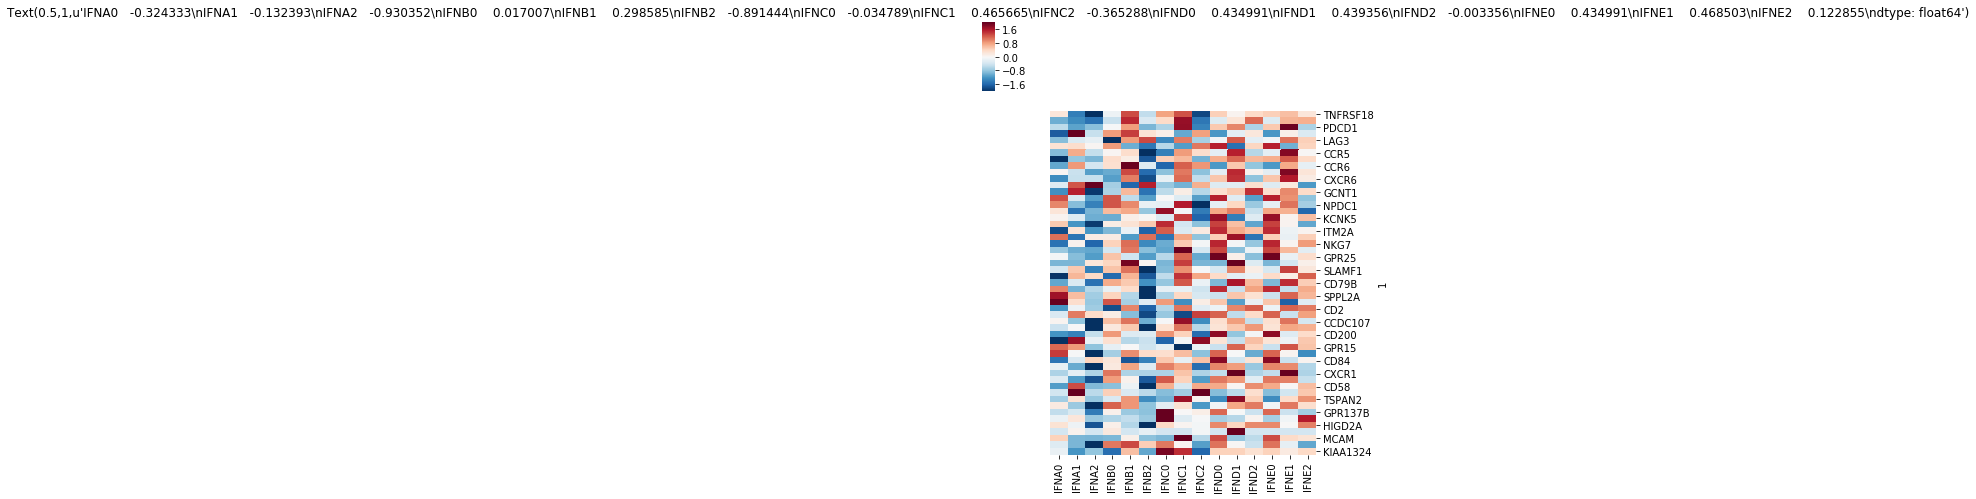

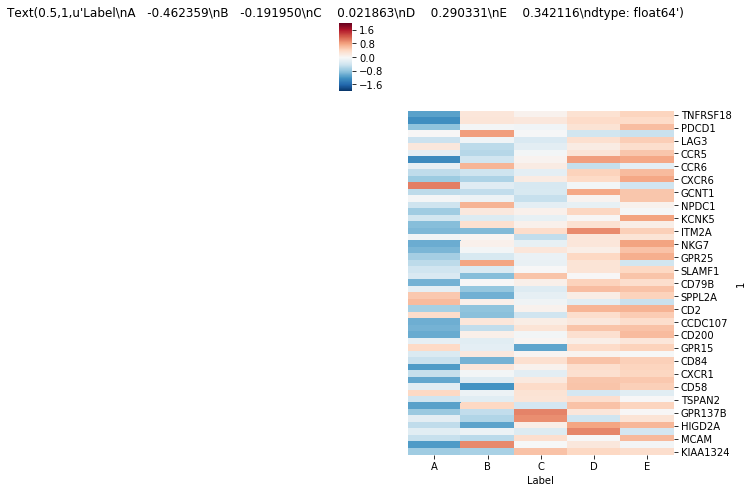

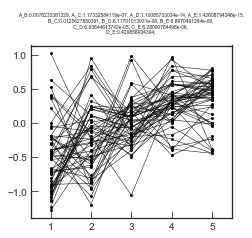

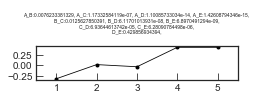

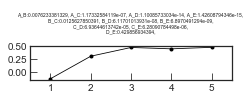

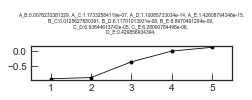

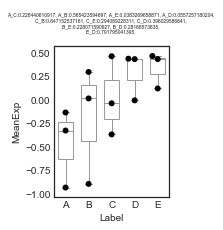

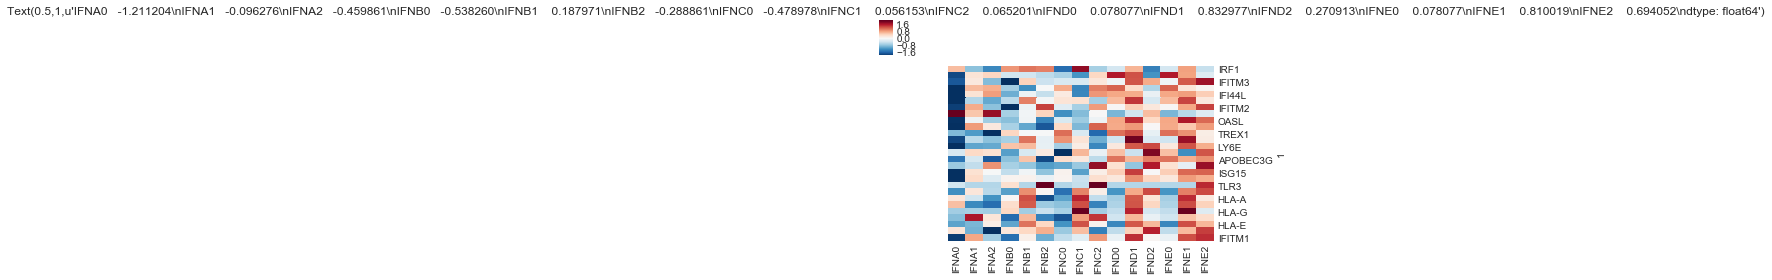

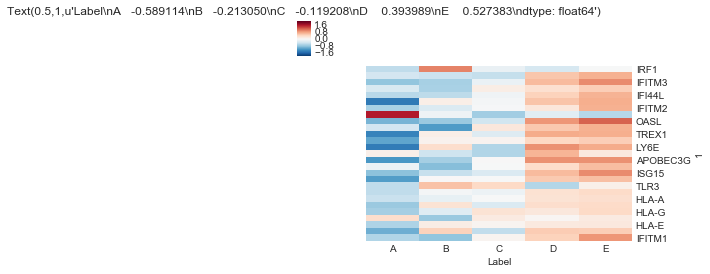

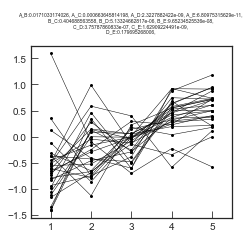

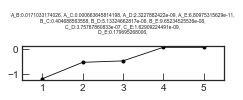

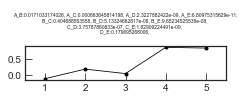

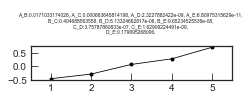

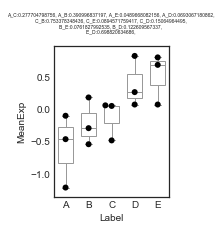

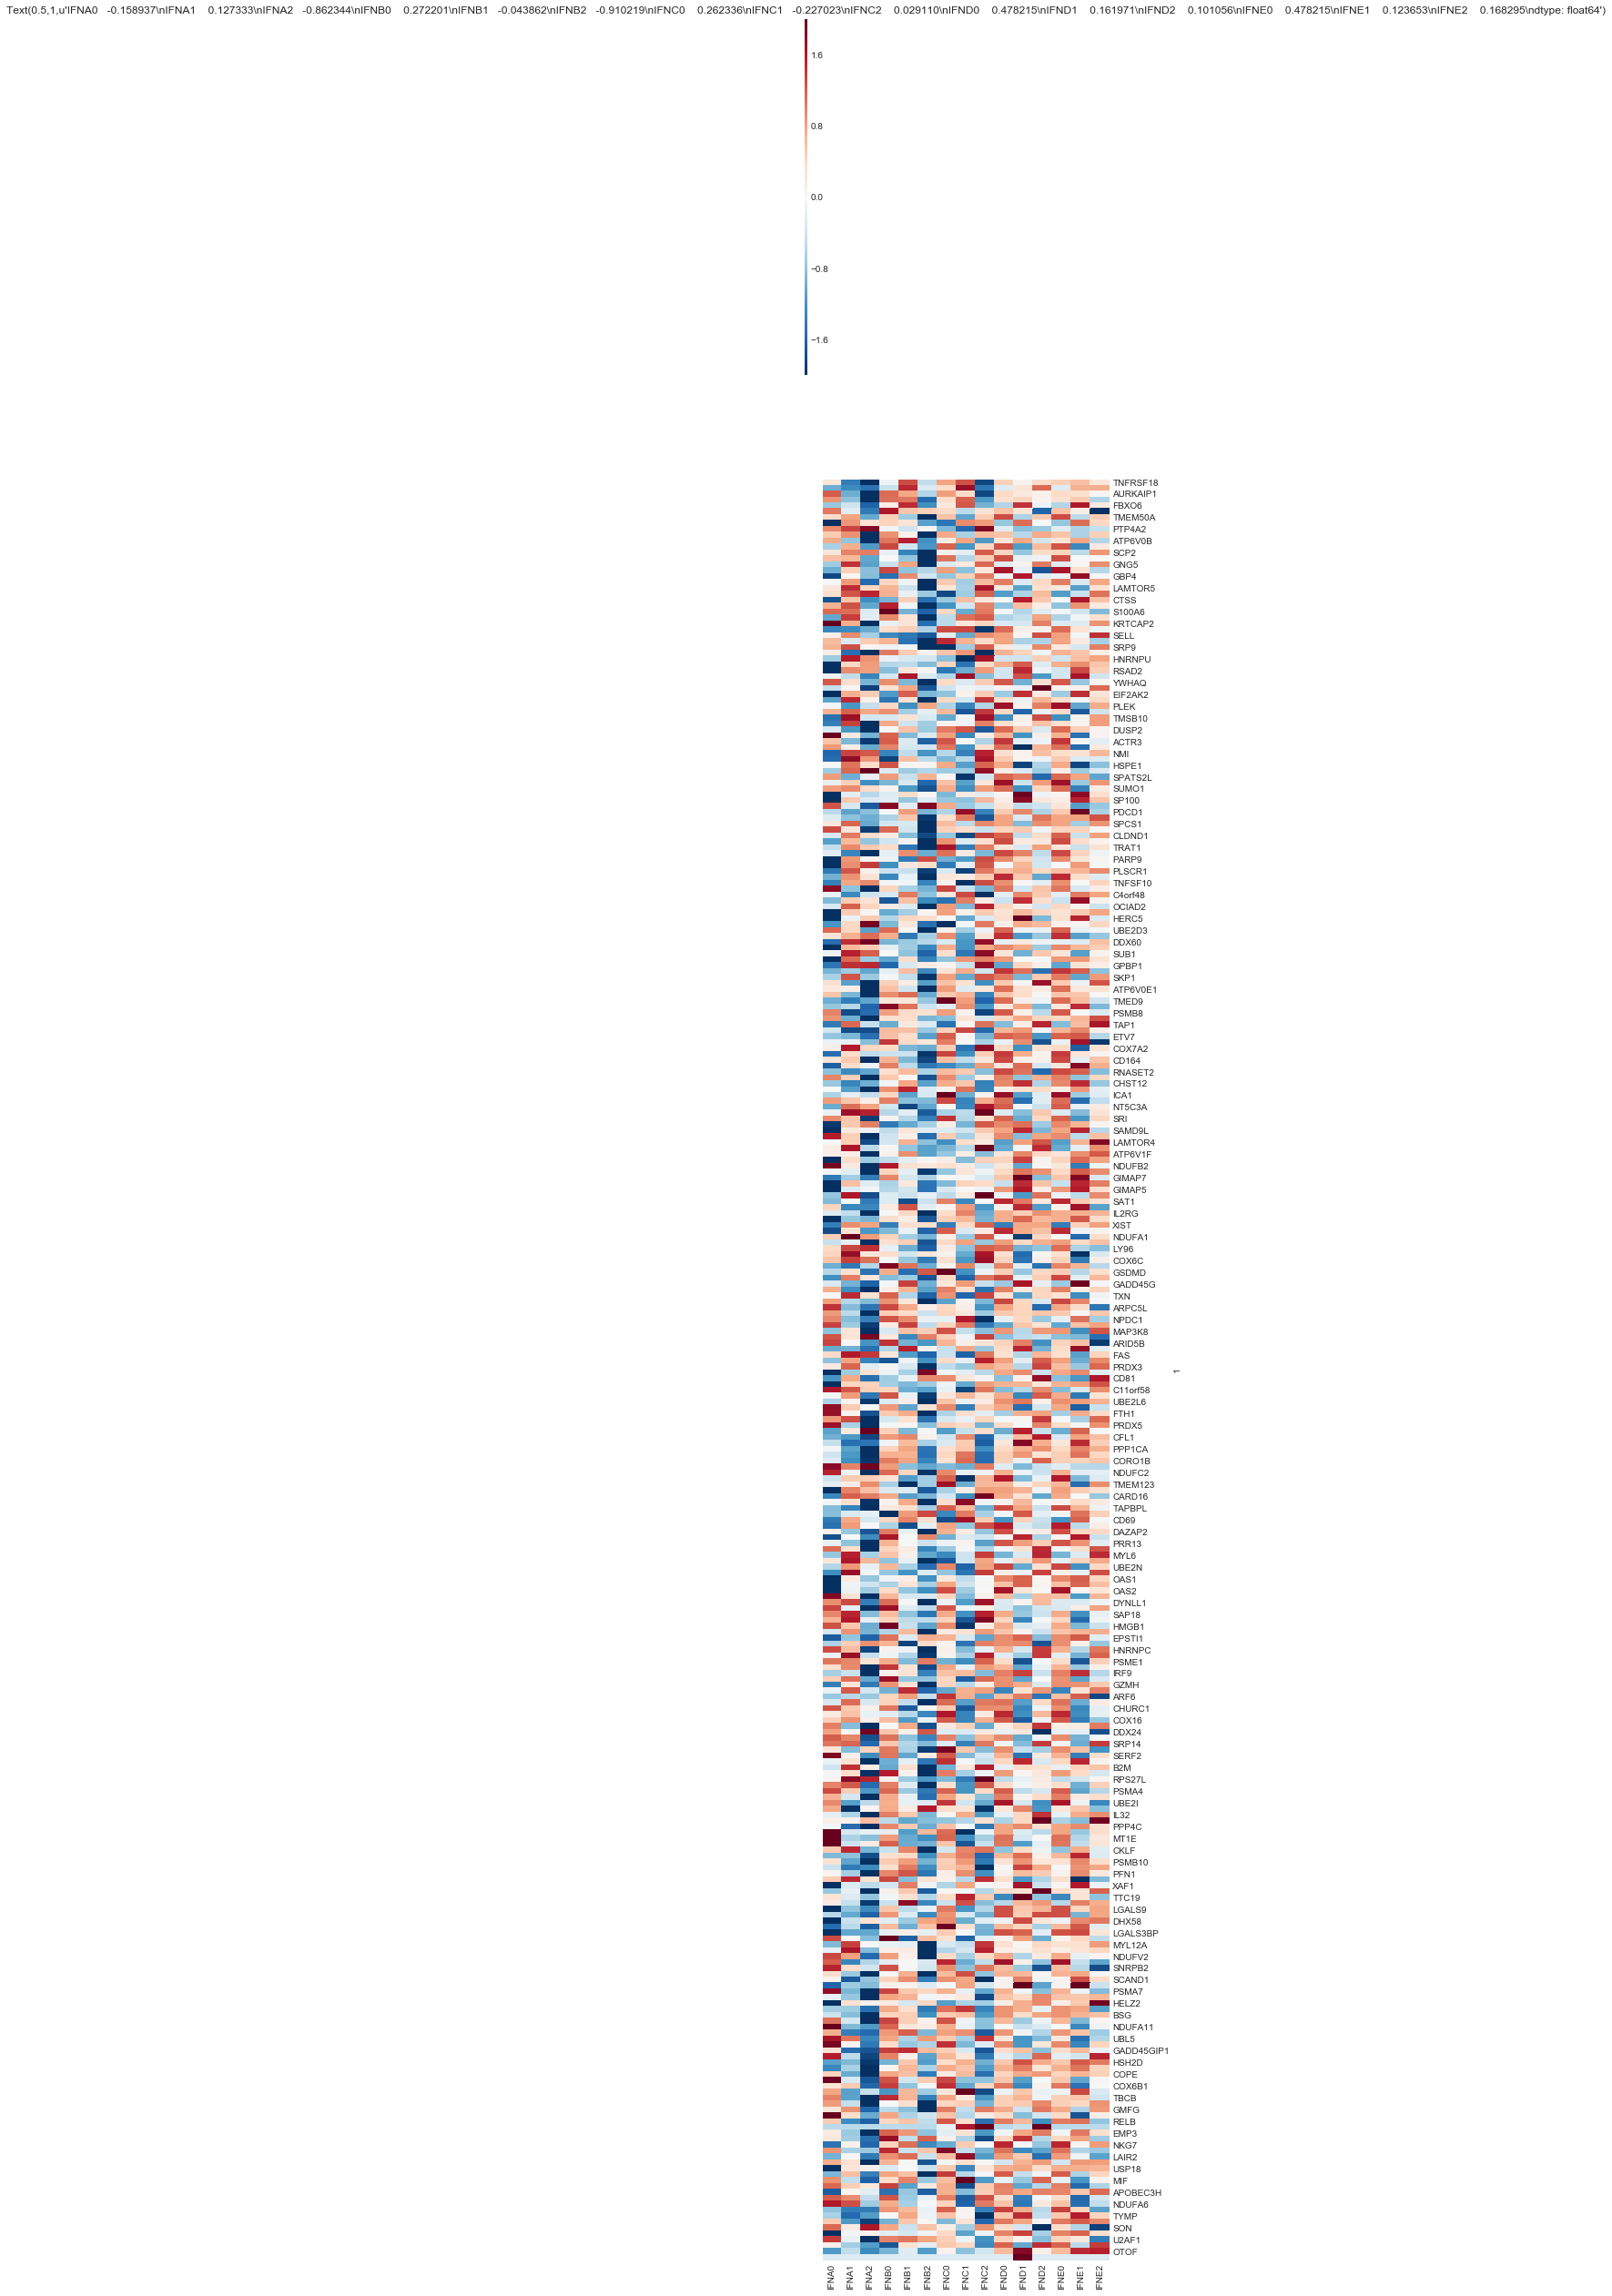

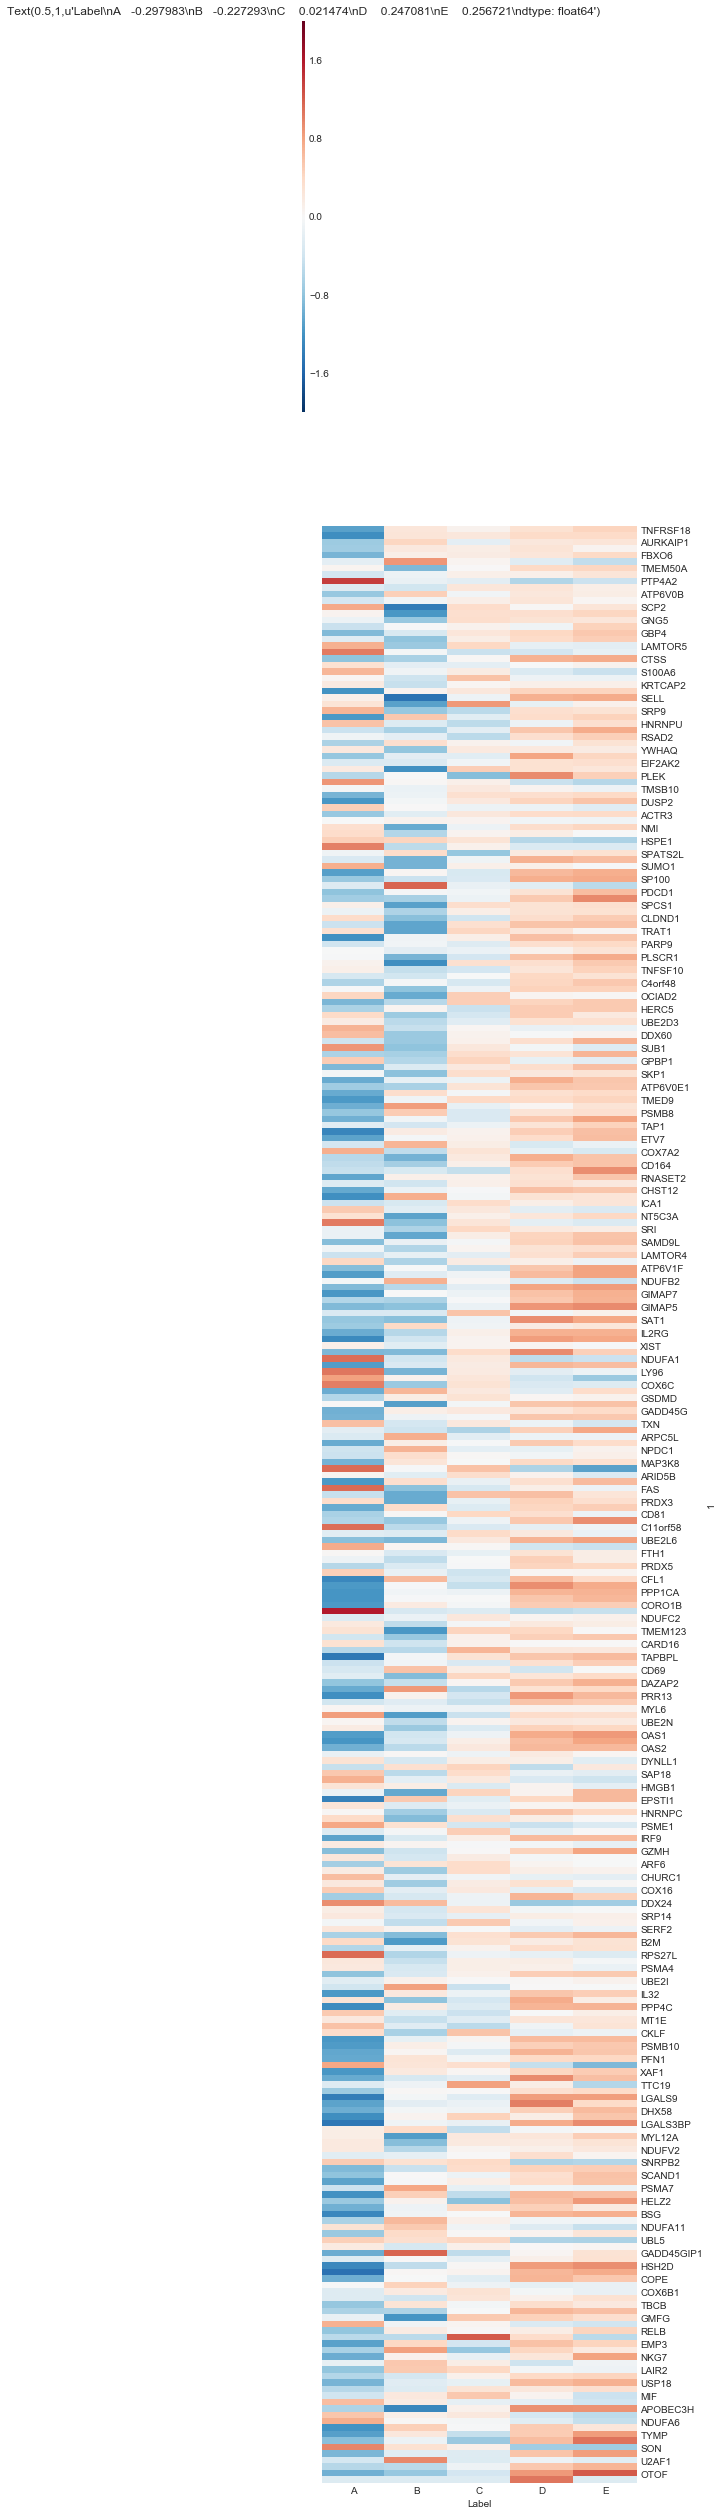

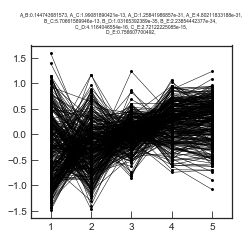

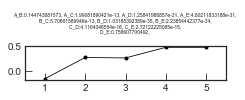

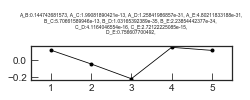

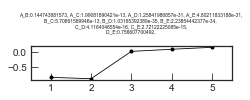

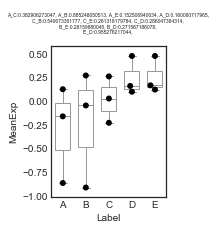

/Users/liuqian/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:2247: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


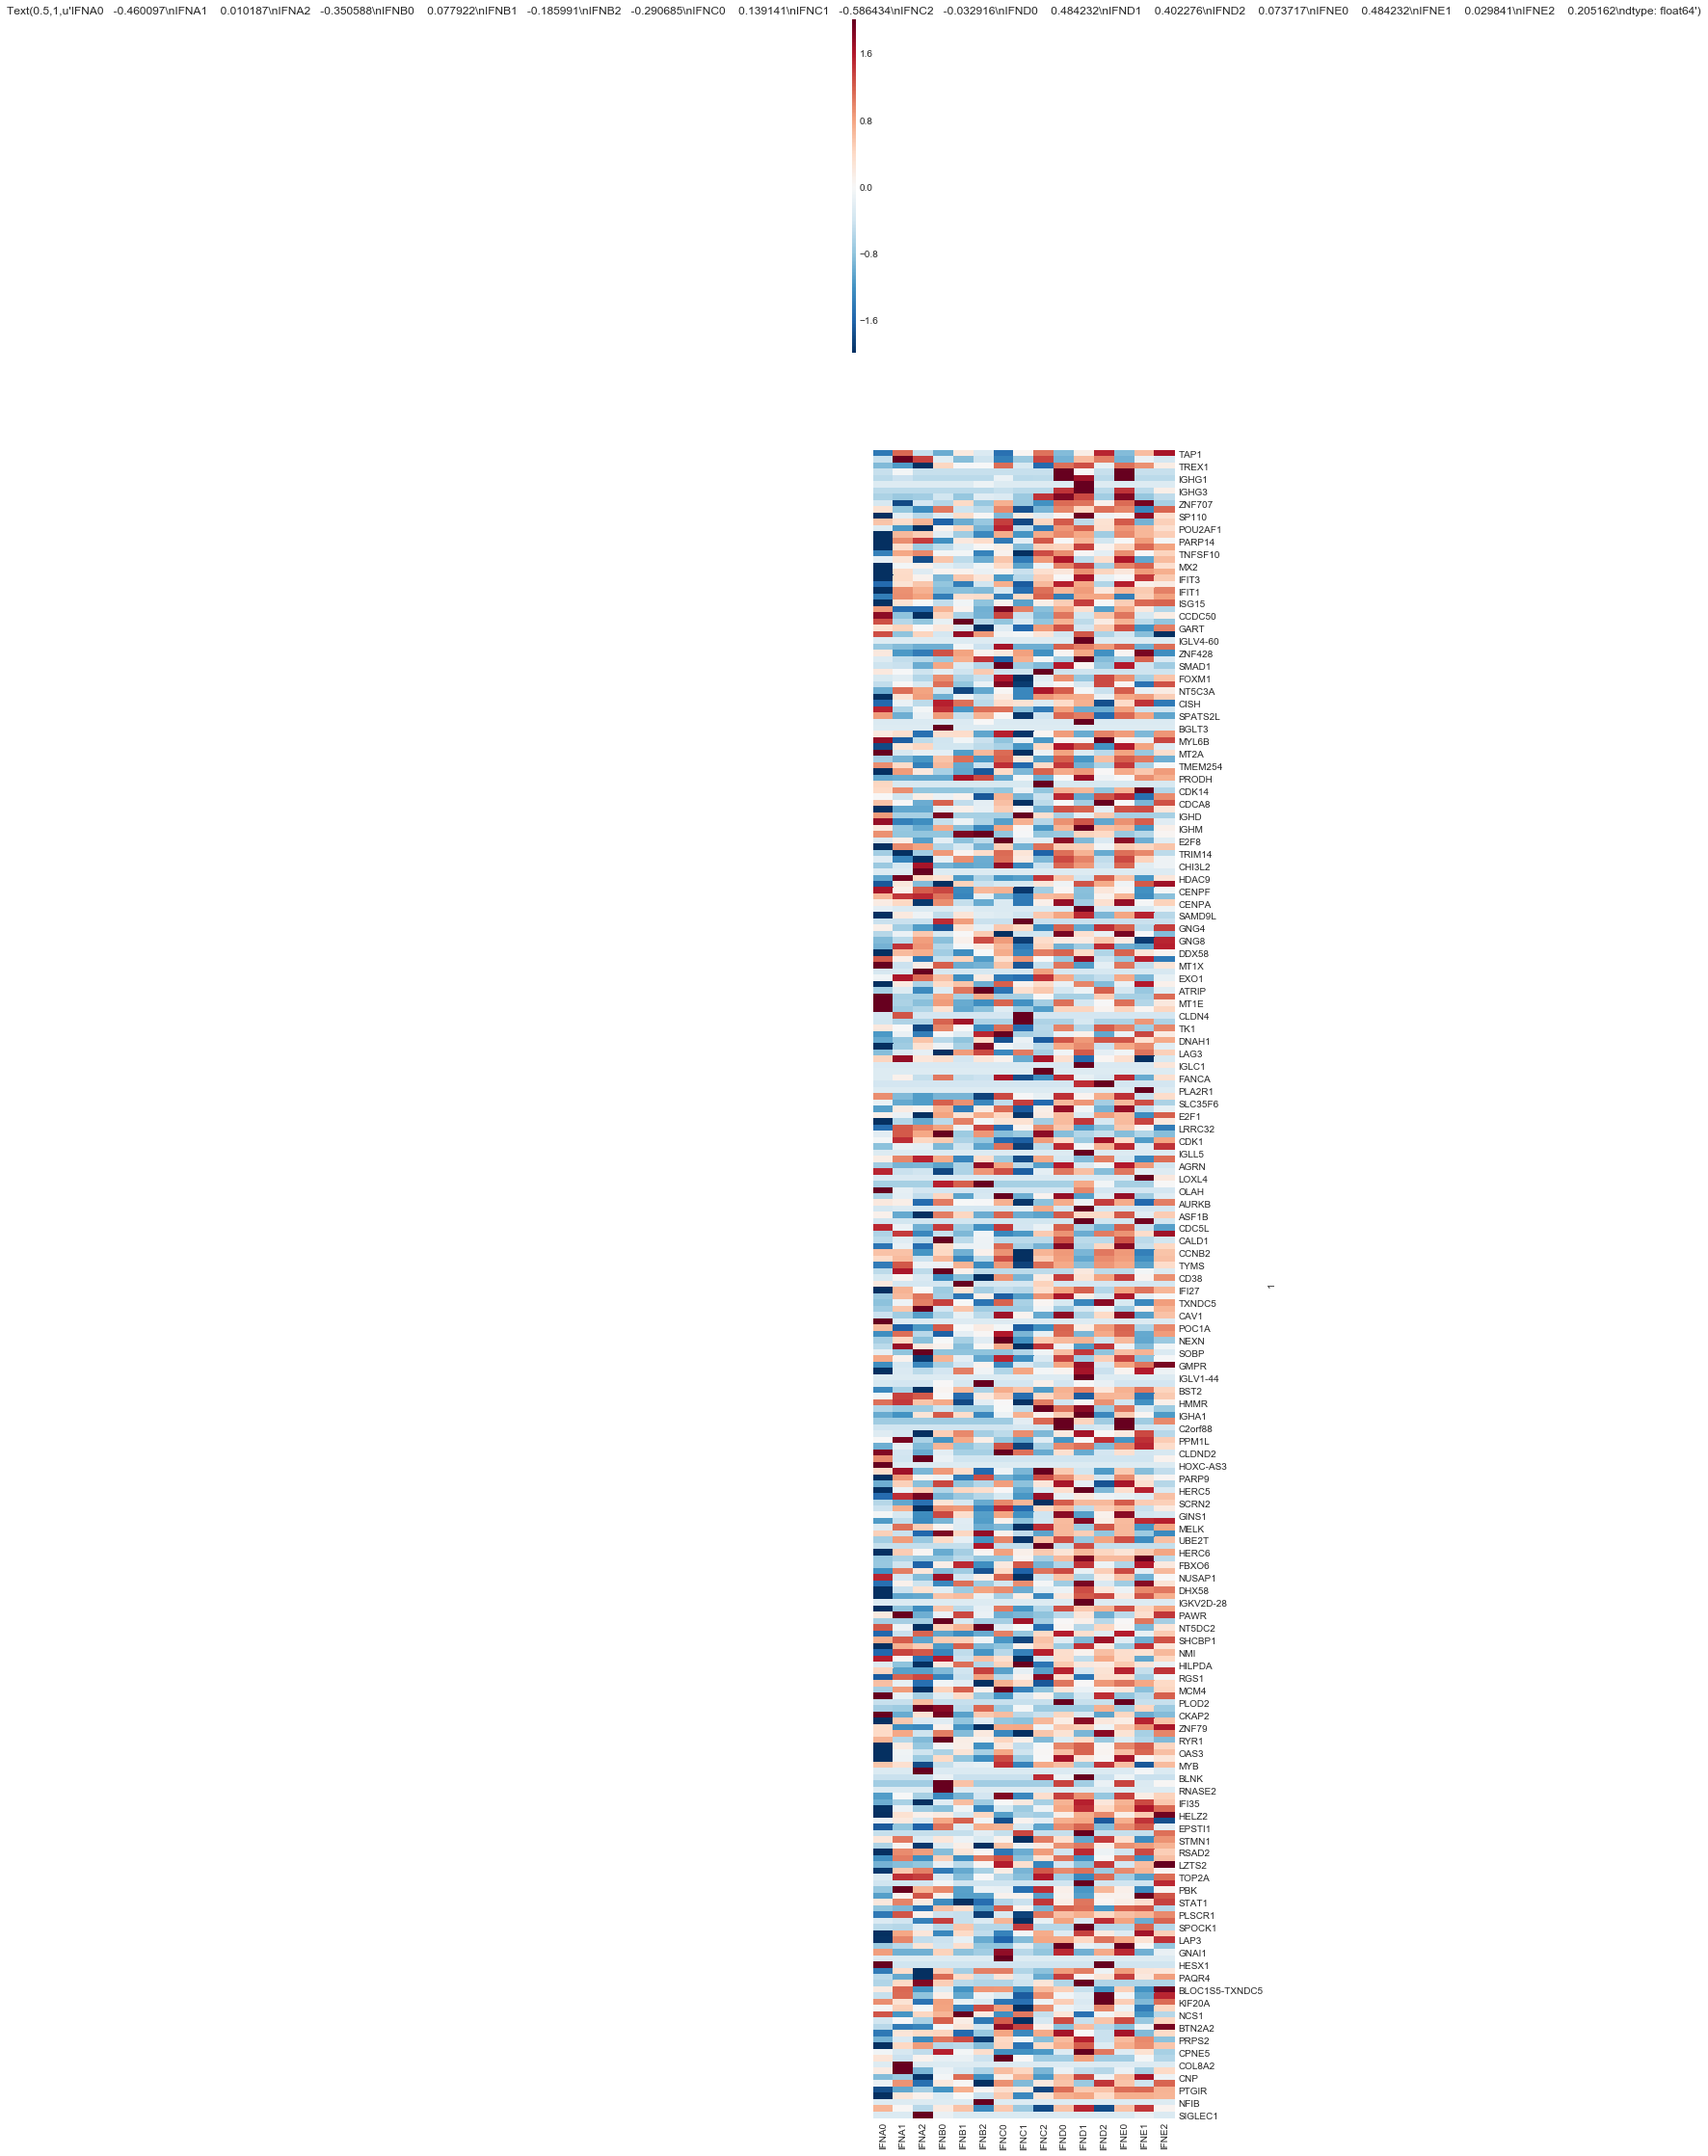

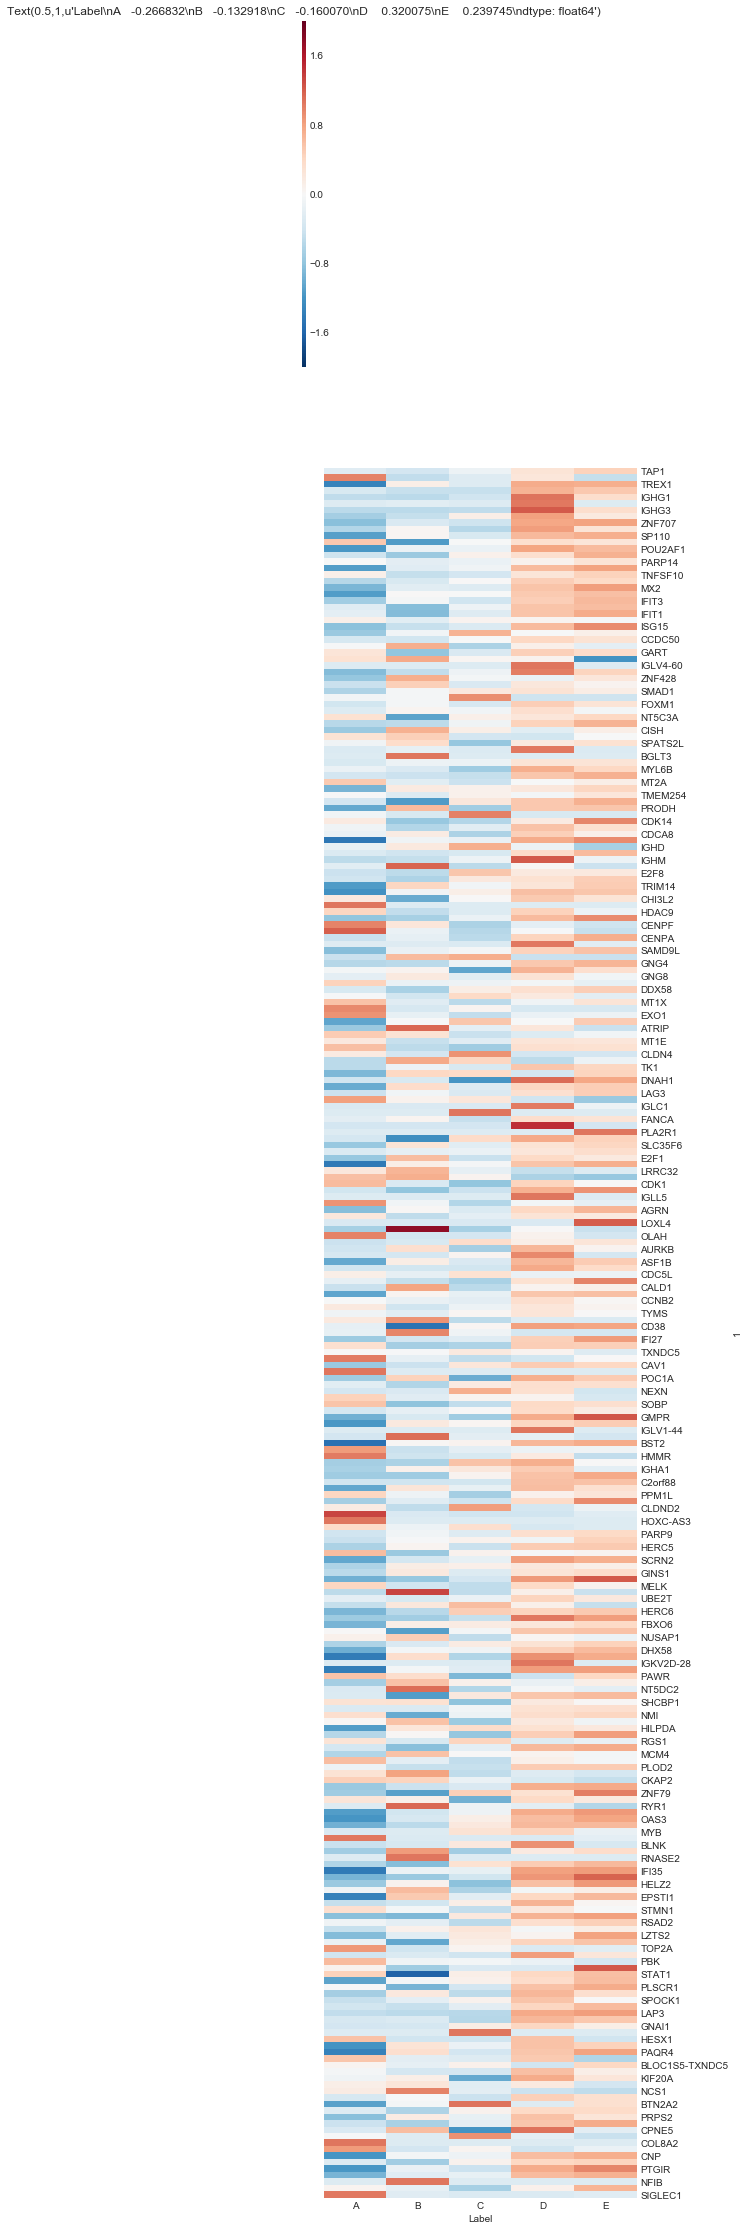

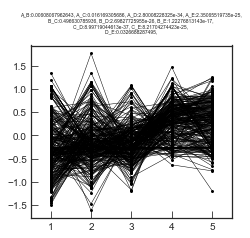

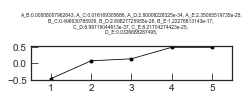

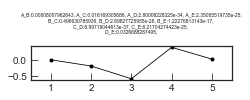

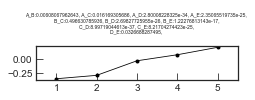

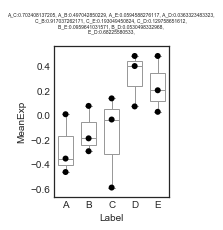

In [13]:
ADF,BDF=Analysis(FPKMExpDF_log,'Treg Exhaustion','TregExh_FPKMExpDF_log',ExpDir)
ADF,BDF=Analysis(FPKMExpDF_log,'Type I Interferon response','IFN1Response_FPKMExpDF_log',ExpDir)
ADF,BDF=Analysis(FPKMExpDF_log,'Patients_TregSpecificGenes','Patients_TregSpecificGenes_FPKMExpDF_log',ExpDir)
ADF,BDF=Analysis(FPKMExpDF_log,'SLE Up regulated genes in CD4+ T cell','FPKMExp_SLEUpRegulatedGenes',ExpDir)



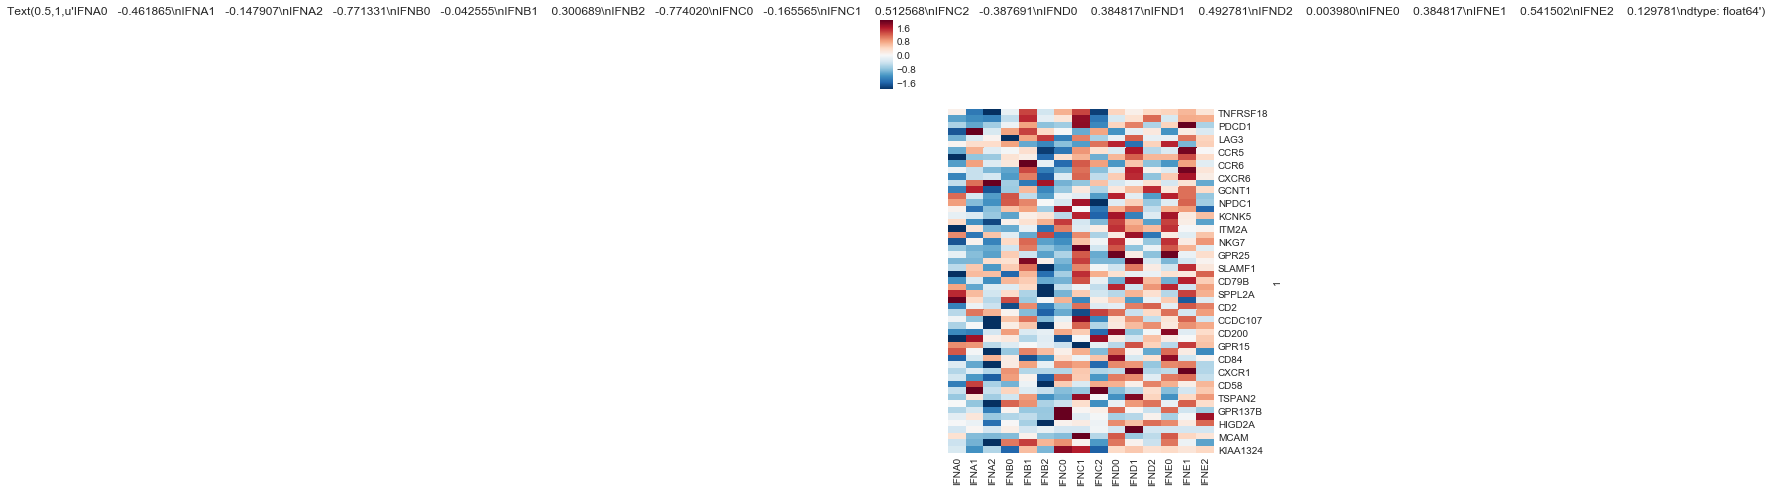

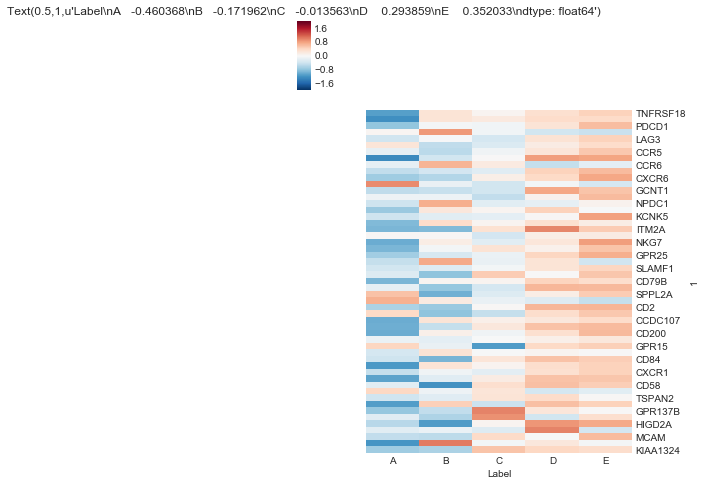

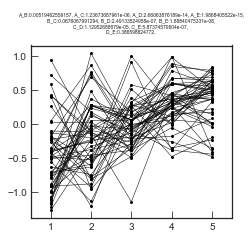

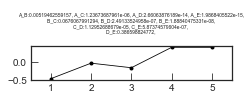

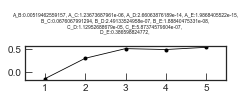

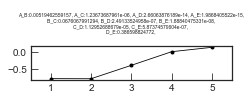

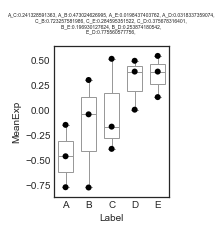

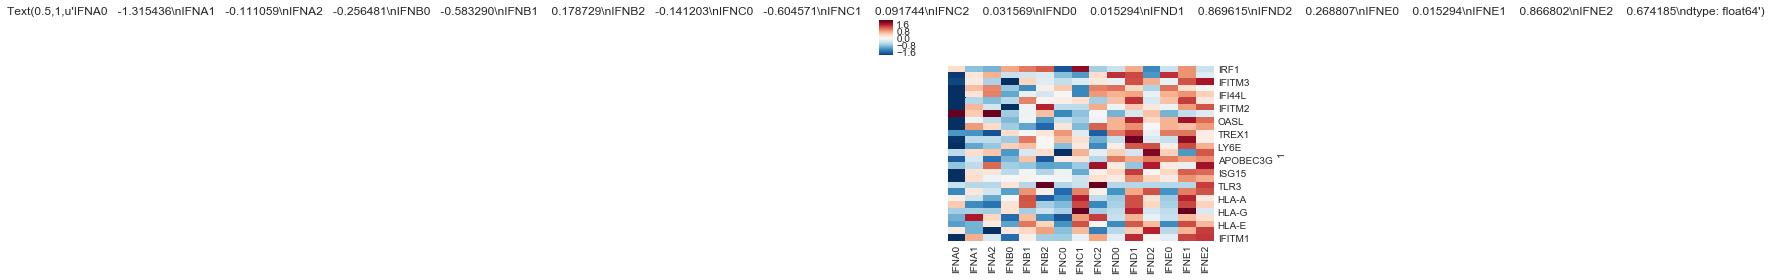

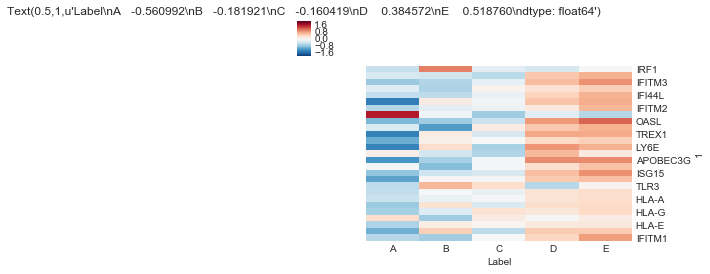

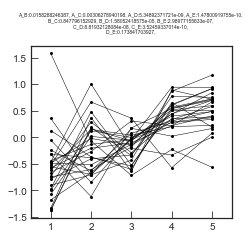

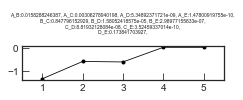

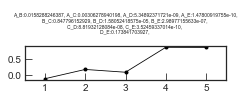

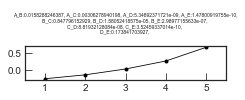

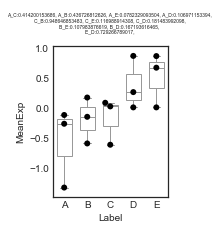

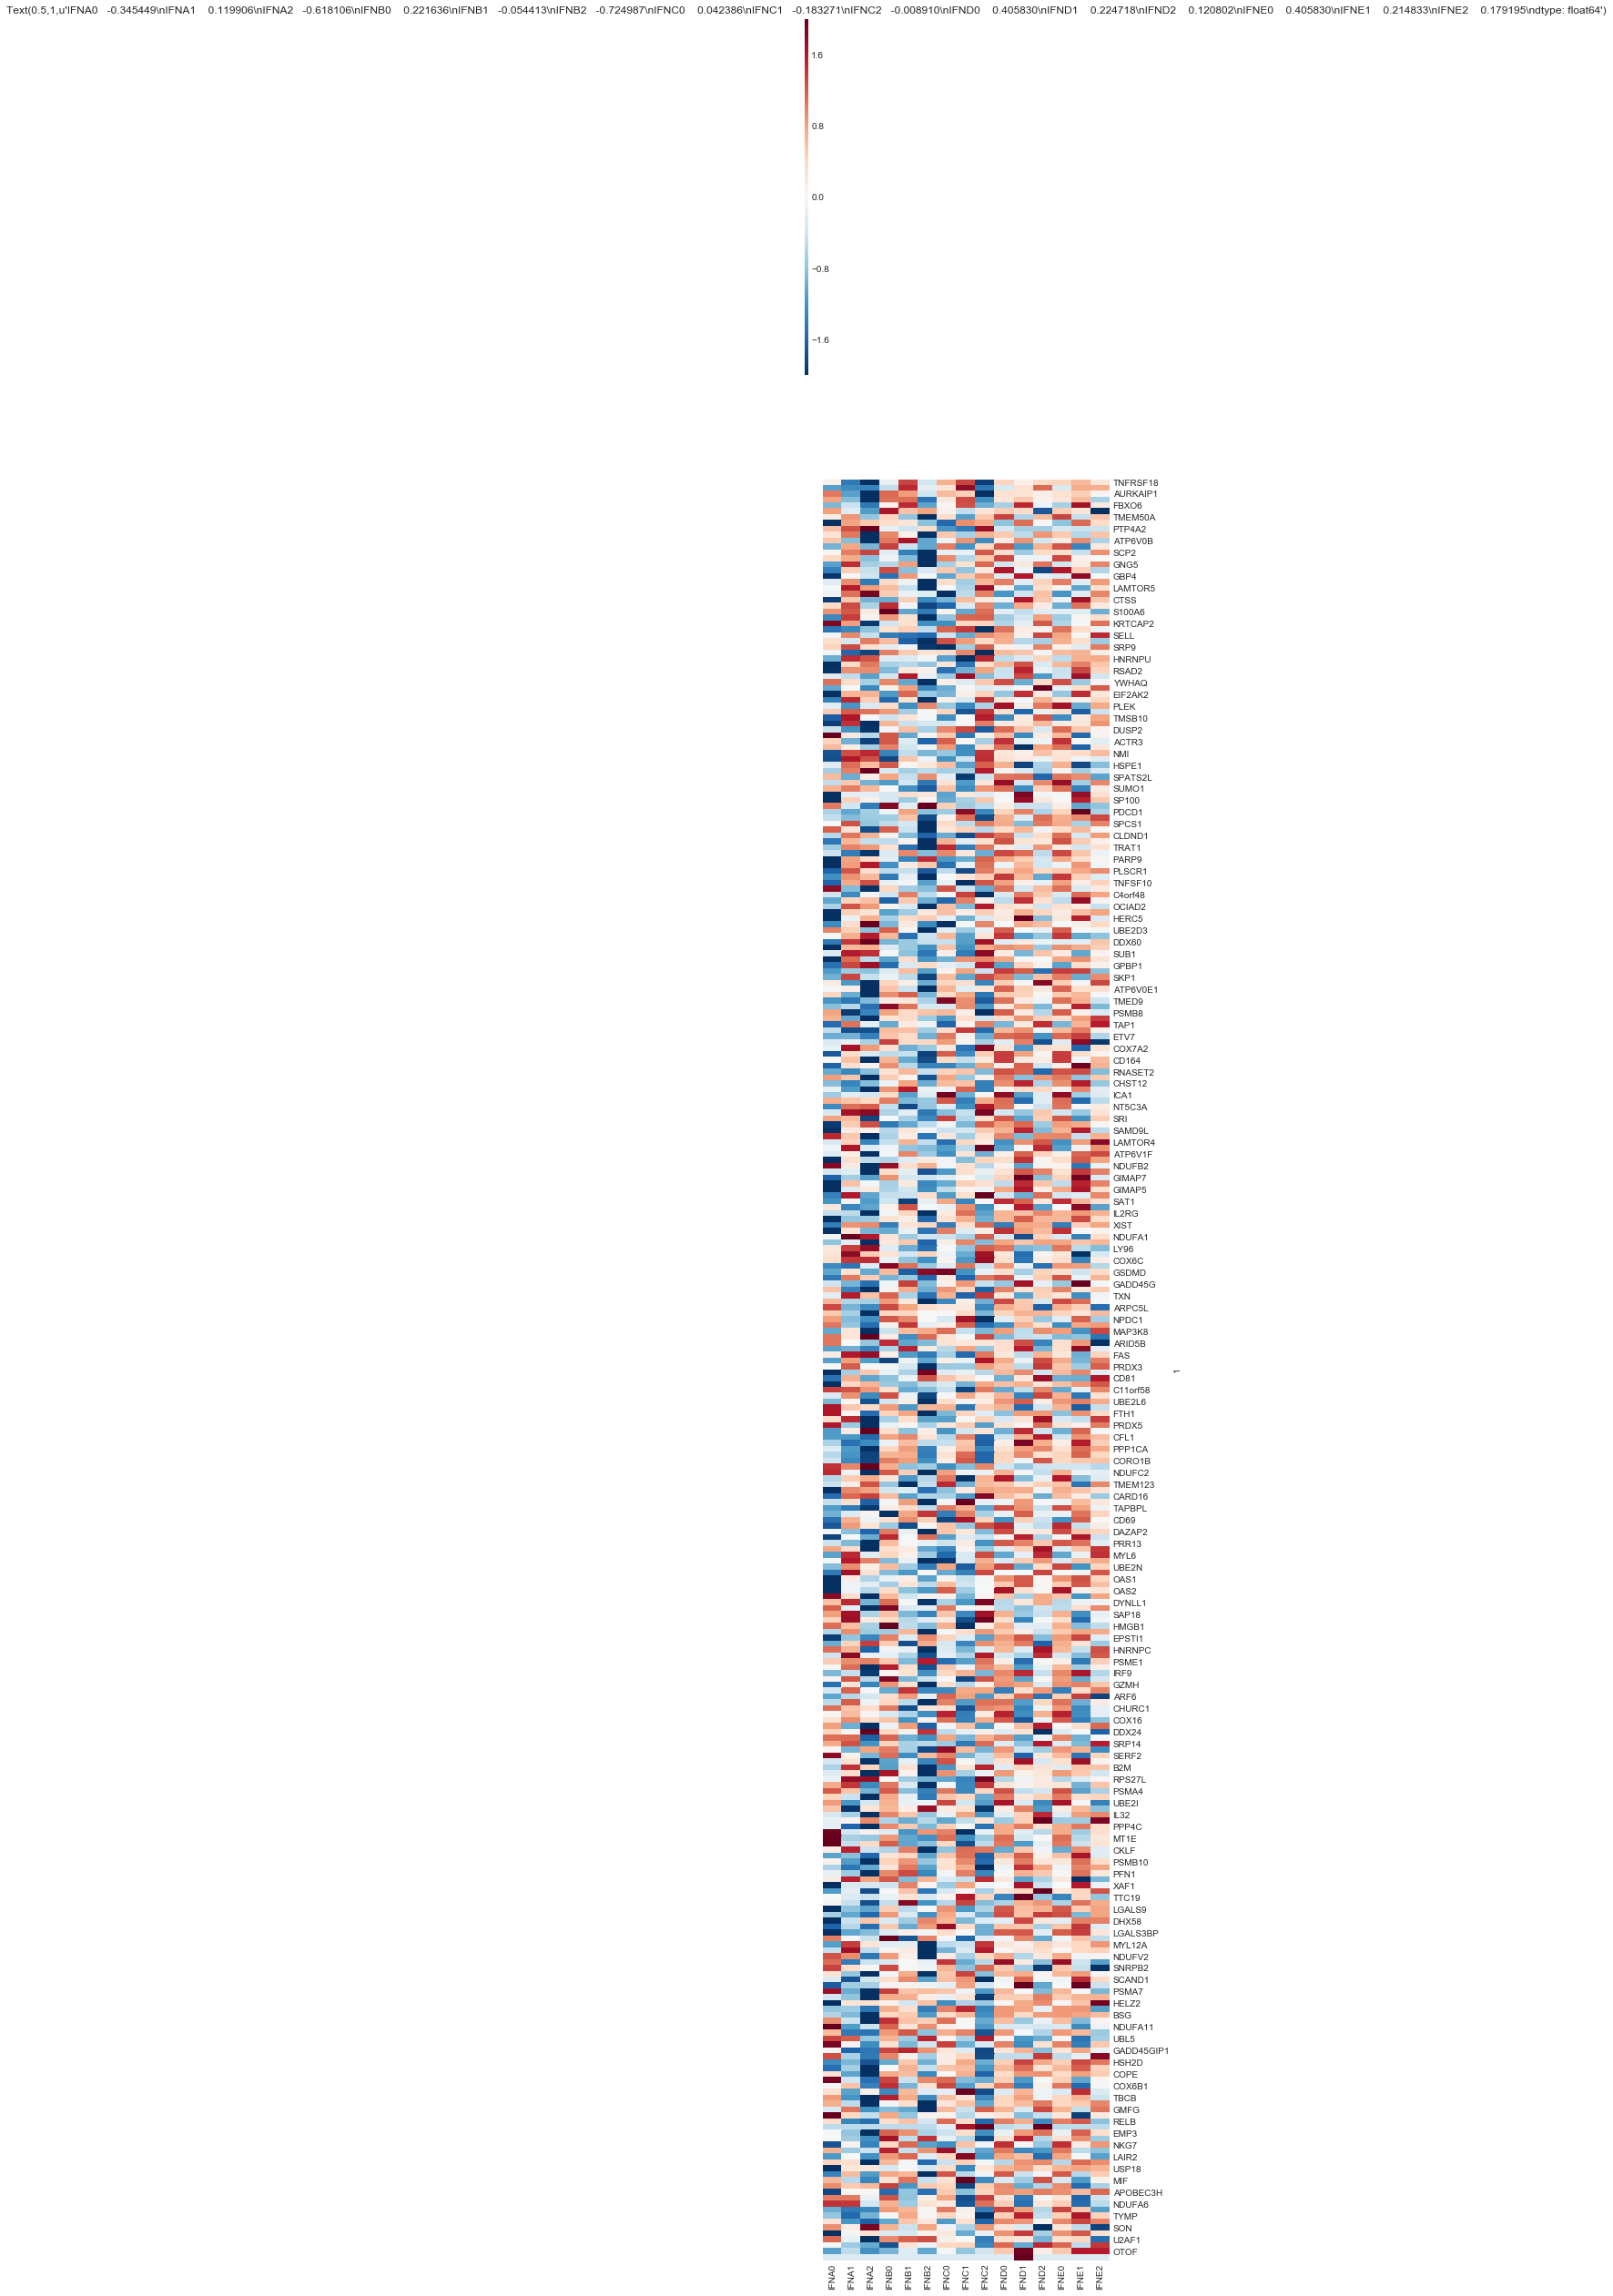

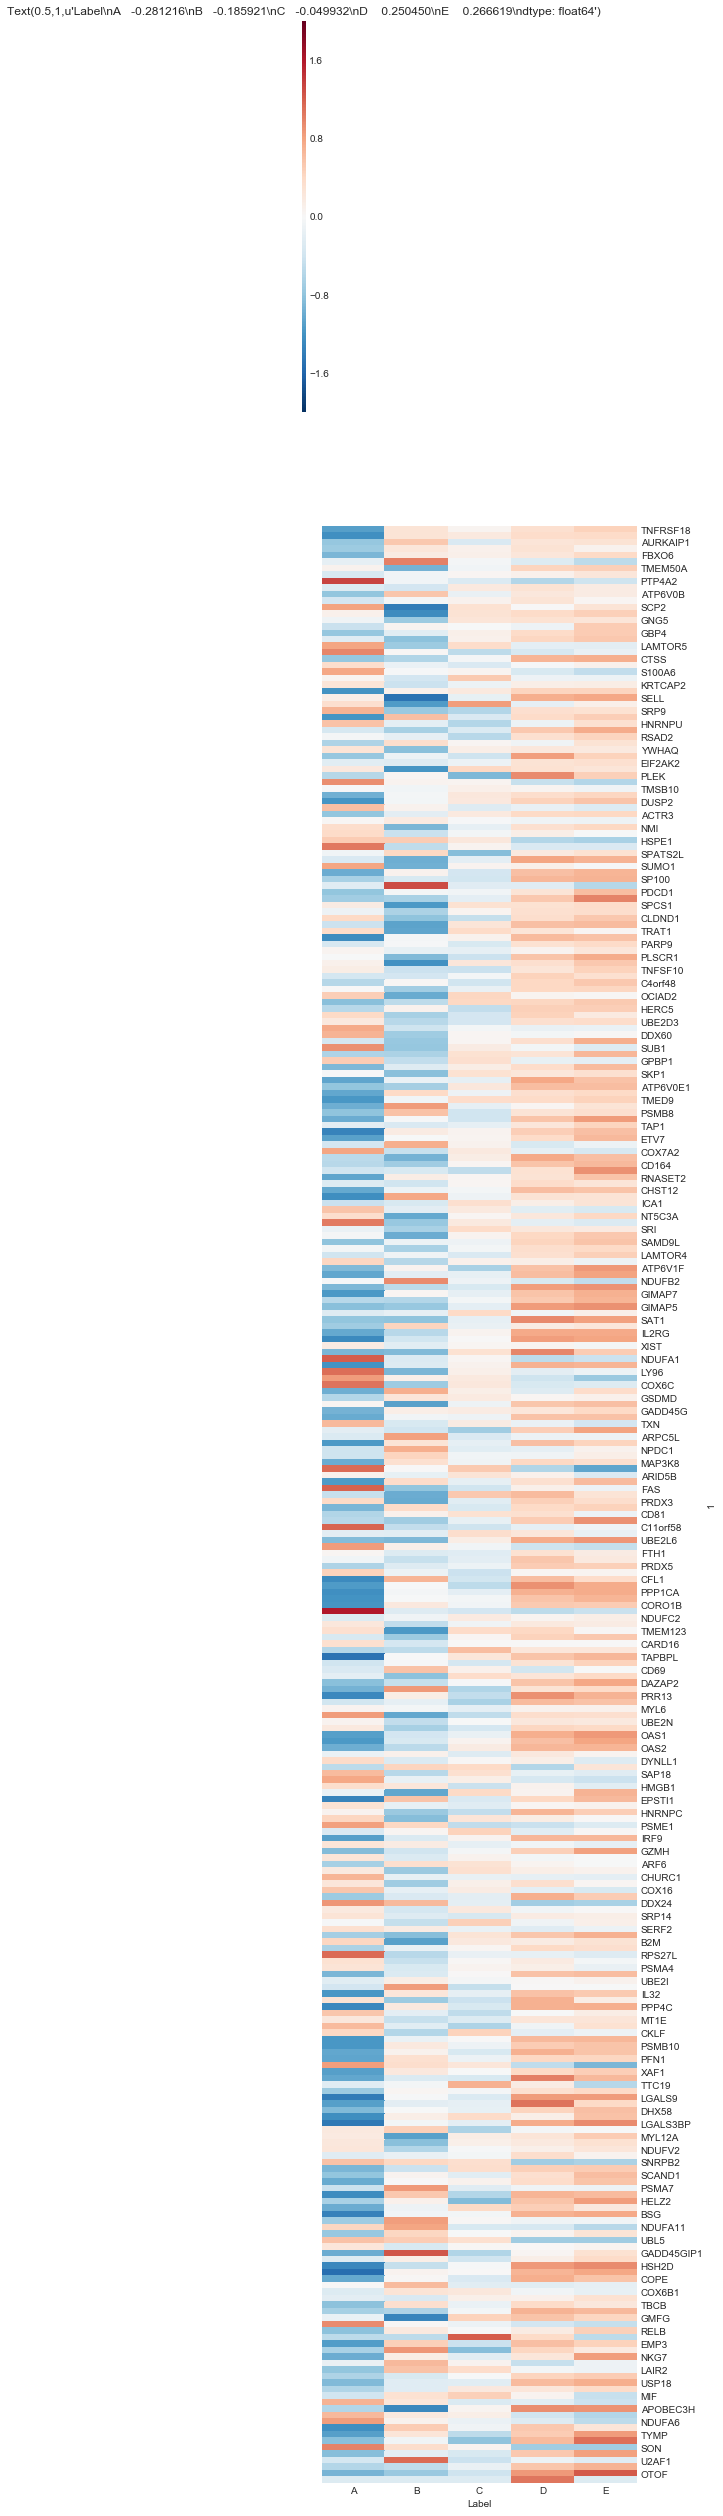

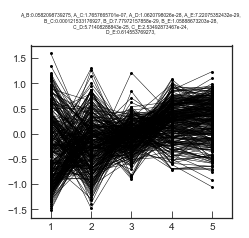

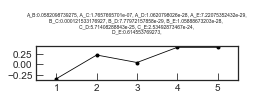

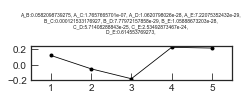

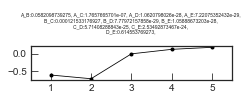

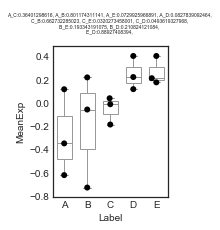

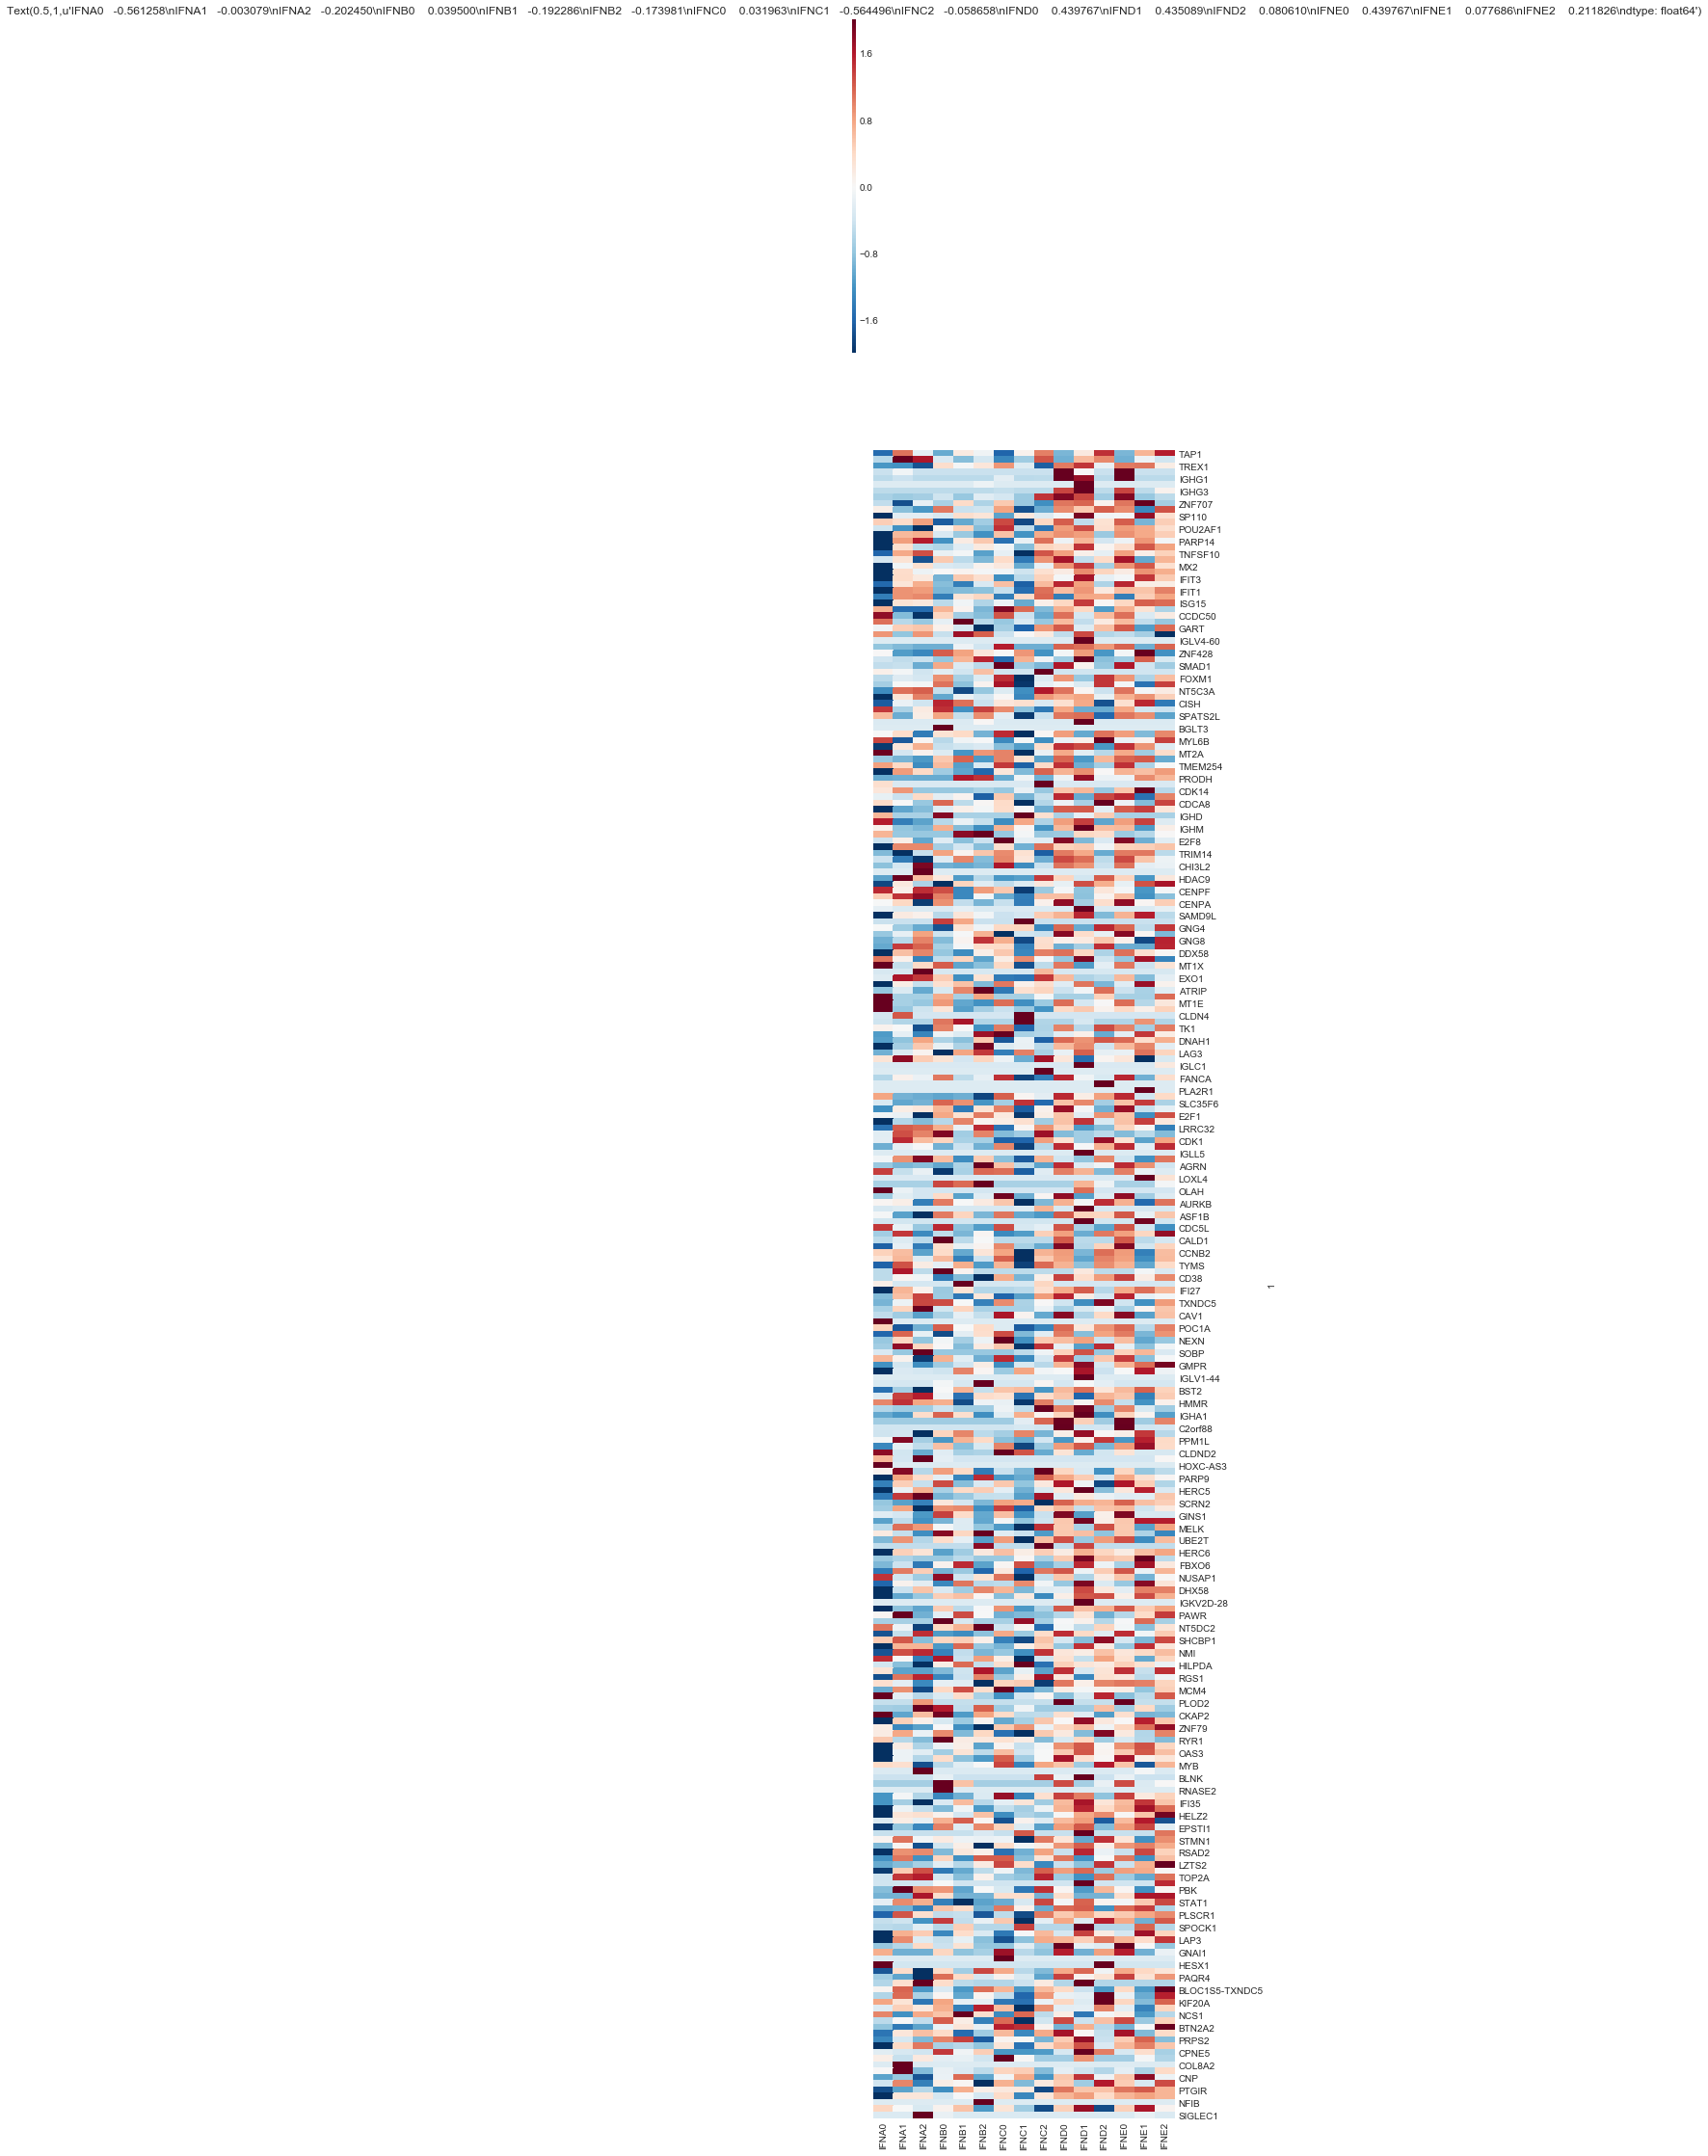

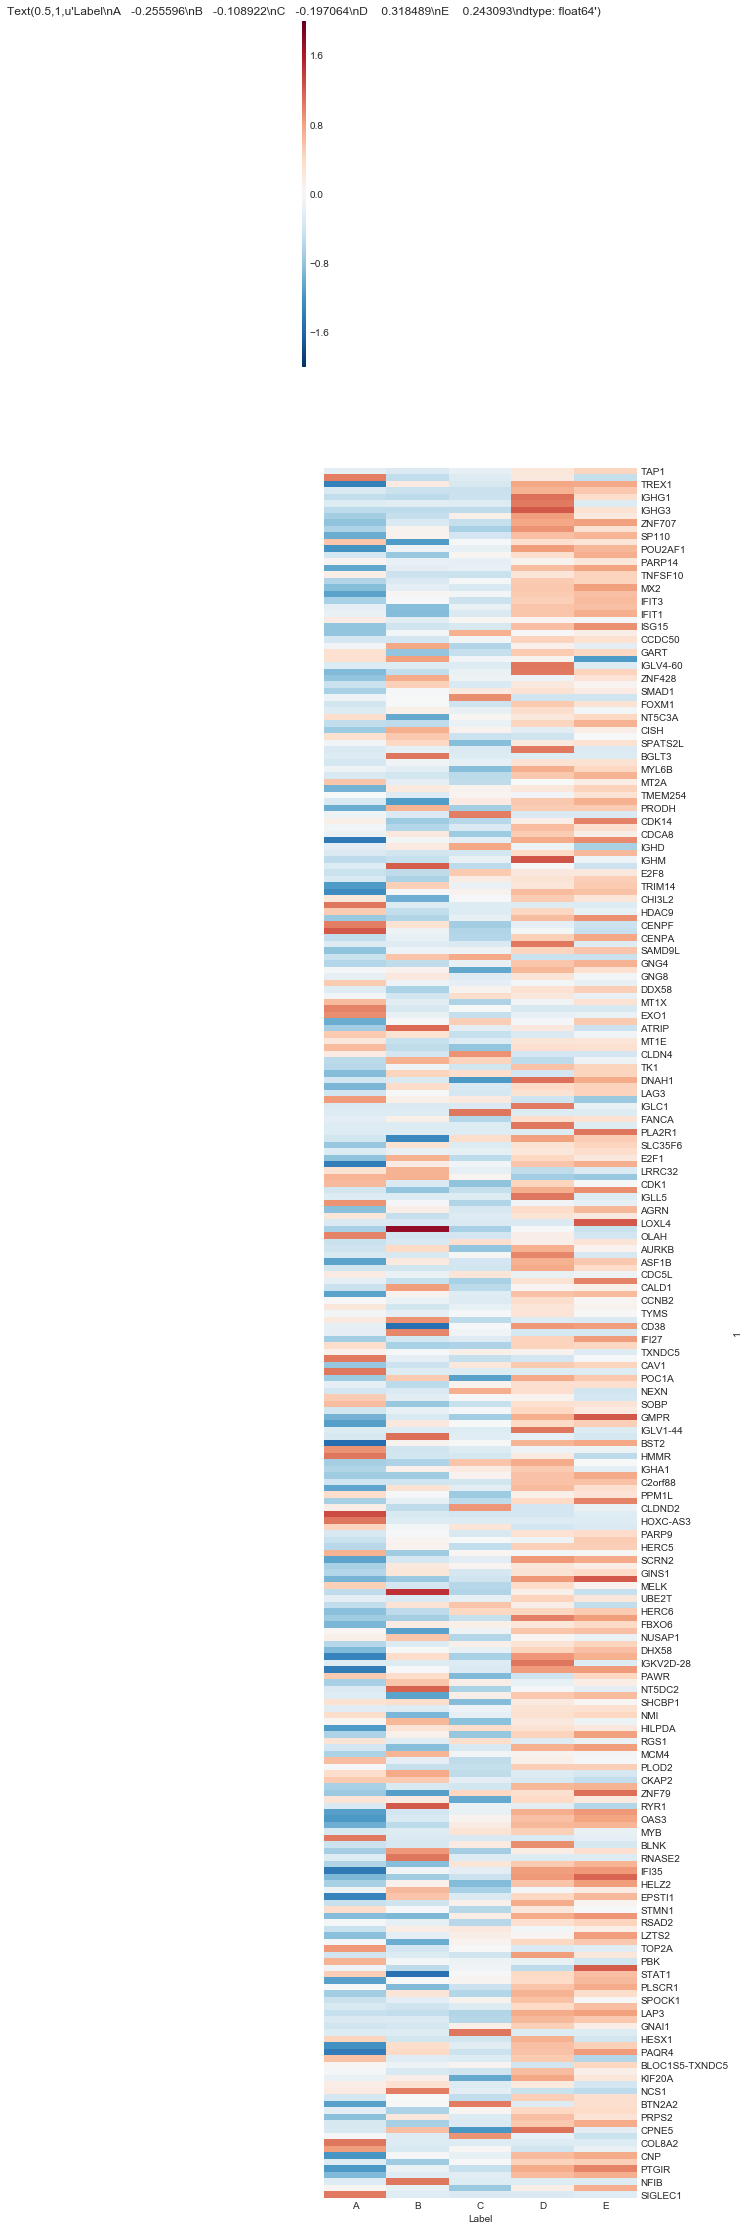

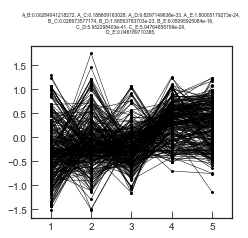

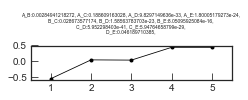

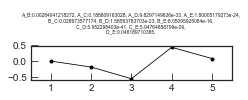

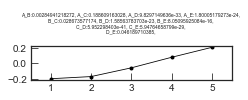

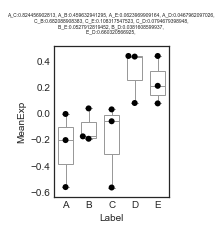

In [15]:
ADF,BDF=Analysis(TPMExpDF_log,'Treg Exhaustion','TregExh_TPMExpDF_log',ExpDir)
ADF,BDF=Analysis(TPMExpDF_log,'Type I Interferon response','IFN1Response_TPMExpDF_log',ExpDir)
ADF,BDF=Analysis(TPMExpDF_log,'Patients_TregSpecificGenes','Patients_TregSpecificGenes_TPMExpDF_log',ExpDir)
ADF,BDF=Analysis(TPMExpDF_log,'SLE Up regulated genes in CD4+ T cell','TPMExp_SLEUpRegulatedGenes',ExpDir)



In [18]:
Signature['Patients_TregSpecificGenes'].dropna()

0      TNFRSF18
1       TNFRSF4
2      AURKAIP1
3          ENO1
4         FBXO6
5         SRRM1
6       TMEM50A
7          CD52
8        ATPIF1
9        PTP4A2
10        PSMB2
11      ATP6V0B
12        PRDX1
13         SCP2
14       TMEM59
15         GNG5
16         GBP1
17         GBP4
18        PSMA5
19      LAMTOR5
20       CAPZA1
21         CTSS
22      S100A11
23       S100A6
24       S100A4
25      KRTCAP2
26       SH2D2A
27         SELL
28        PTPRC
29        IKBKE
         ...   
301        HCST
302        TBCB
303        ECH1
304        GMFG
305       RPS19
306        RELB
307       IGFL2
308        EMP3
309         BAX
310        NKG7
311      NDUFA3
312       LAIR2
313      CHMP2A
314       USP18
315      RANBP1
316         MIF
317      UQCR10
318    APOBEC3H
319        RBX1
320      NDUFA6
321        PIM3
322        SCO2
323        TYMP
324       ODF3B
325         SON
326         MX2
327       U2AF1
328        GNG4
329        OTOF
330       IGLL5
Name: Patients_TregSpeci